In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
df.shape

(145460, 23)

Удалим столбцы

In [4]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [5]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [6]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

In [7]:
df[df['RainTomorrow']==0.0].count()

Rainfall        97103
Humidity3pm     97103
Pressure9am     97103
RainToday       97103
RainTomorrow    97103
dtype: int64

In [8]:
df[df['RainTomorrow']==1.0].count()

Rainfall        27586
Humidity3pm     27586
Pressure9am     27586
RainToday       27586
RainTomorrow    27586
dtype: int64

Классы несбалансированы

In [9]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [10]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [11]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
    
    # torch.nn.init.xavier_uniform_(self.fc1.weight) 

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [12]:
criterion = nn.BCELoss()

In [13]:
device = torch.device( "cpu")

In [14]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [15]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [16]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
        
    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.572073757648468, accuracy: 0.7959740161895752
    
epoch 200
    Test  set - loss: 0.5436038970947266, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333545207977295, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.515478789806366, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.4807439148426056, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.467812716960907, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.4557793438434601, accuracy: 0.784826397895813
    
epoch 800
    Test  set - loss: 0.44448351860046387, accuracy: 0.7911219596862793
    
epoch 900
    Test  set - loss: 0.433699369430542, accuracy: 0.7984200716018677
    
epoch 1000
    Test  set - loss: 0.42425426840782166, accuracy: 0.8102895021438599
    
epoch 1100
    Test  set - loss: 0.417177677154541, accurac

In [17]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [18]:
net = torch.load(MODEL_PATH)

C:\Users\Svetlana\AppData\Local\Temp\ipykernel_15136\804352145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [19]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



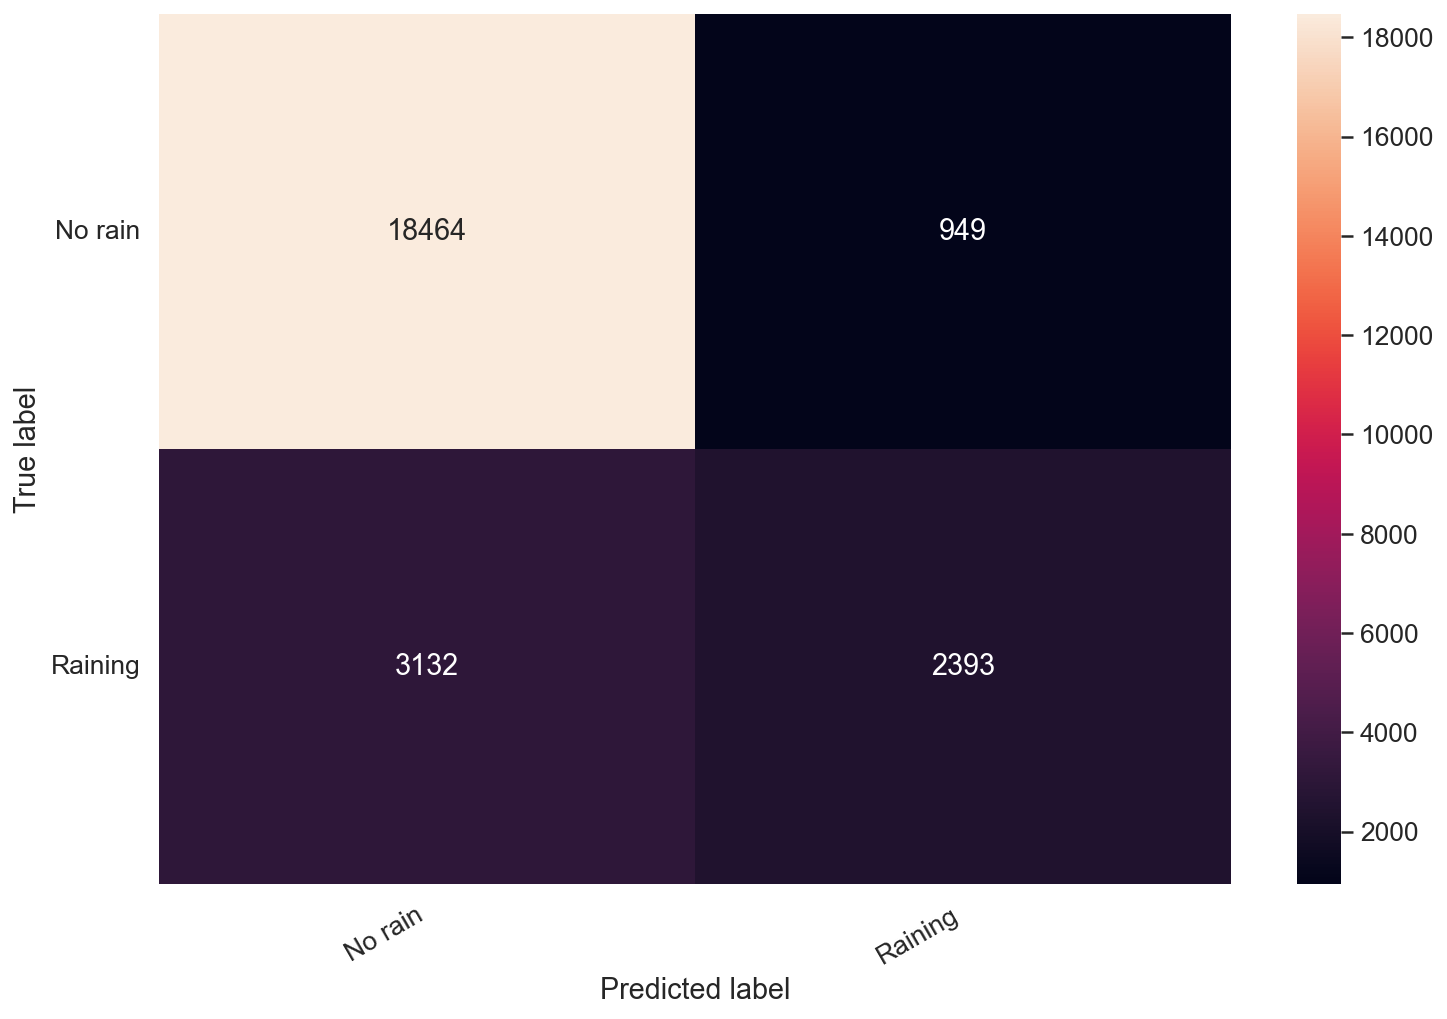

In [34]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [12]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, 
# выберите оптимальное значение.

# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [41]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_df(path='weatherAUS.csv'):
    df = pd.read_csv(path).dropna()
    df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1}).astype(int)
    df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(int)
    return df

def convert_X_to_tensor(X, is_scaled):
    return torch.from_numpy(X if is_scaled else X.to_numpy()).float()

def convert_y_to_tensor(y, is_scaled):
    # Исправлено: метки классов должны быть типа torch.long
    return torch.squeeze(torch.from_numpy(y if is_scaled else y.to_numpy()).long())

def get_X_y_tensor(df, is_scaled=False):
    X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
    y = df[['RainTomorrow']]

    if is_scaled:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        y = scaler.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = convert_X_to_tensor(X_train, is_scaled).to(device)
    y_train = convert_y_to_tensor(y_train, is_scaled).to(device)
    X_test = convert_X_to_tensor(X_test, is_scaled).to(device)
    y_test = convert_y_to_tensor(y_test, is_scaled).to(device)

    return X_train, X_test, y_train, y_test

# Модель нейронной сети
class Net(nn.Module):
    def __init__(self, n_features, hidden_layers=[8, 4], activation_fn=F.relu):
        super(Net, self).__init__()
        layers = []
        input_size = n_features
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU() if activation_fn == F.relu else activation_fn)
            input_size = hidden_size
        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())  # Для бинарной классификации
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Подсчет точности
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(0.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

def calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer, criterion=nn.BCELoss().to(device)):
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(num_epochs):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())  # Убедитесь, что y_train преобразован в float

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())  # Убедитесь, что y_test преобразован в float
            test_acc = calculate_accuracy(y_test, y_test_pred)

            print(f'Epoch {epoch}, Loss: {test_loss.item()}, Accuracy: {test_acc.item()}')
            epoch_losses.append(test_loss.item())
            epoch_accuracies.append(test_acc.item())

    return epoch_losses, epoch_accuracies

def visualize_results(results, title=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 строка, 3 столбца
    
    for param, metrics in results.items():
        losses = metrics["losses"]
        accuracies = metrics["accuracies"]
        epochs = range(0, len(losses) * 100, 100)
        
        # Loss plot
        axes[0].plot(epochs, losses, label=f'{param}')
        axes[0].set_title("Loss", fontsize=14)
        axes[0].set_xlabel("Epochs", fontsize=12)
        axes[0].set_ylabel("Loss", fontsize=12)
        axes[0].grid(True, linestyle="--", alpha=0.7)
        axes[0].set_yscale('log')

        # Accuracy plot
        axes[1].plot(epochs, accuracies, label=f'{param}')
        axes[1].set_title("Accuracy", fontsize=14)
        axes[1].set_xlabel("Epochs", fontsize=12)
        axes[1].set_ylabel("Accuracy", fontsize=12)
        axes[1].grid(True, linestyle="--", alpha=0.7)

        # Combined plot
        axes[2].plot(epochs, losses, label=f'Loss ({param})', color='red', alpha=0.7)
        axes[2].plot(epochs, accuracies, label=f'Accuracy ({param})', color='blue', alpha=0.7)
        axes[2].set_title("Loss & Accuracy", fontsize=14)
        axes[2].set_xlabel("Epochs", fontsize=12)
        axes[2].legend()
        axes[2].grid(True, linestyle="--", alpha=0.7)

    for ax in axes:
        ax.legend(fontsize=10)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

Epoch 0, Loss: 20.443761825561523, Accuracy: 0.7797766923904419
Epoch 100, Loss: 20.443761825561523, Accuracy: 0.7797766923904419
Epoch 200, Loss: 20.443761825561523, Accuracy: 0.7797766923904419
Epoch 300, Loss: 20.443761825561523, Accuracy: 0.7797766923904419
Epoch 400, Loss: 20.443761825561523, Accuracy: 0.7797766923904419
Epoch 500, Loss: 20.443761825561523, Accuracy: 0.7797766923904419
Epoch 600, Loss: 20.443761825561523, Accuracy: 0.7797766923904419
Epoch 700, Loss: 20.443761825561523, Accuracy: 0.7797766923904419
Epoch 800, Loss: 20.443761825561523, Accuracy: 0.7797766923904419
Epoch 900, Loss: 20.443761825561523, Accuracy: 0.7797766923904419
Epoch 0, Loss: 3.355616569519043, Accuracy: 0.7796880602836609
Epoch 100, Loss: 1.1927591562271118, Accuracy: 0.63071608543396
Epoch 200, Loss: 0.8454585671424866, Accuracy: 0.6955866813659668
Epoch 300, Loss: 0.6524516940116882, Accuracy: 0.7806628942489624
Epoch 400, Loss: 0.5348373055458069, Accuracy: 0.7878412008285522
Epoch 500, Loss: 

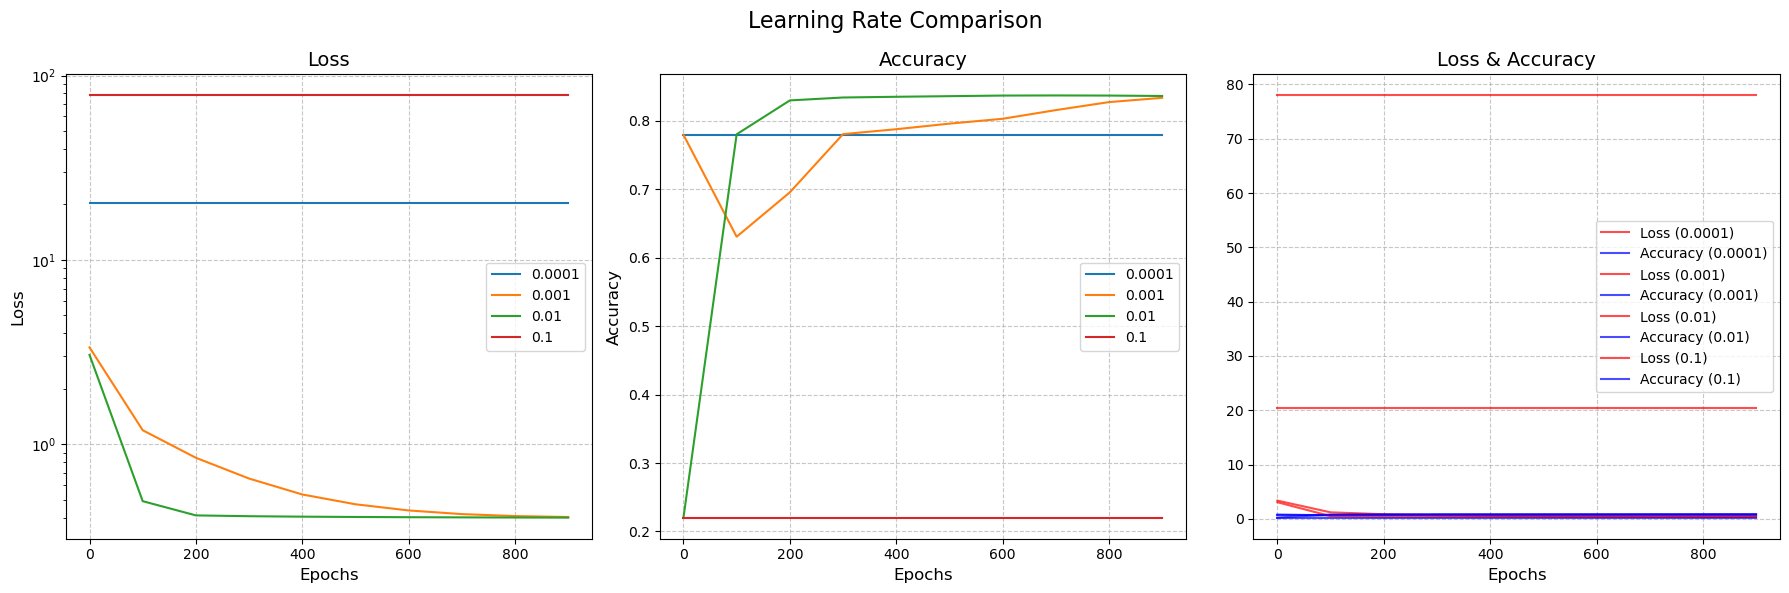

In [42]:
# Получение данных
df = get_df()
X_train, X_test, y_train, y_test = get_X_y_tensor(df)

# Learning rate
results_lr = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    # Рассчитаем потери и точности для текущего learning rate
    net = Net(n_features=X_train.shape[1], activation_fn=F.relu)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    losses, accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, 1000, net, optimizer)
    results_lr[lr] = {'losses': losses, 'accuracies': accuracies}

visualize_results(results_lr, title="Learning Rate Comparison")

Epoch 0, Loss: 0.6732510328292847, Accuracy: 0.7797766923904419
Epoch 100, Loss: 0.48998039960861206, Accuracy: 0.7797766923904419
Epoch 200, Loss: 0.3856427073478699, Accuracy: 0.7797766923904419
Epoch 300, Loss: 0.3697356581687927, Accuracy: 0.7797766923904419
Epoch 400, Loss: 0.36052653193473816, Accuracy: 0.7797766923904419
Epoch 500, Loss: 0.3550912141799927, Accuracy: 0.7797766923904419
Epoch 600, Loss: 0.3518080711364746, Accuracy: 0.7797766923904419
Epoch 700, Loss: 0.3489968478679657, Accuracy: 0.8564338684082031
Epoch 800, Loss: 0.3464926481246948, Accuracy: 0.8589152693748474
Epoch 900, Loss: 0.34432724118232727, Accuracy: 0.8621942400932312
Epoch 0, Loss: 0.6479462385177612, Accuracy: 0.7797766923904419
Epoch 100, Loss: 0.347950279712677, Accuracy: 0.8561680316925049
Epoch 200, Loss: 0.3309783637523651, Accuracy: 0.8608649373054504
Epoch 300, Loss: 0.32555338740348816, Accuracy: 0.8604218363761902
Epoch 400, Loss: 0.3228793740272522, Accuracy: 0.8607763051986694
Epoch 500, 

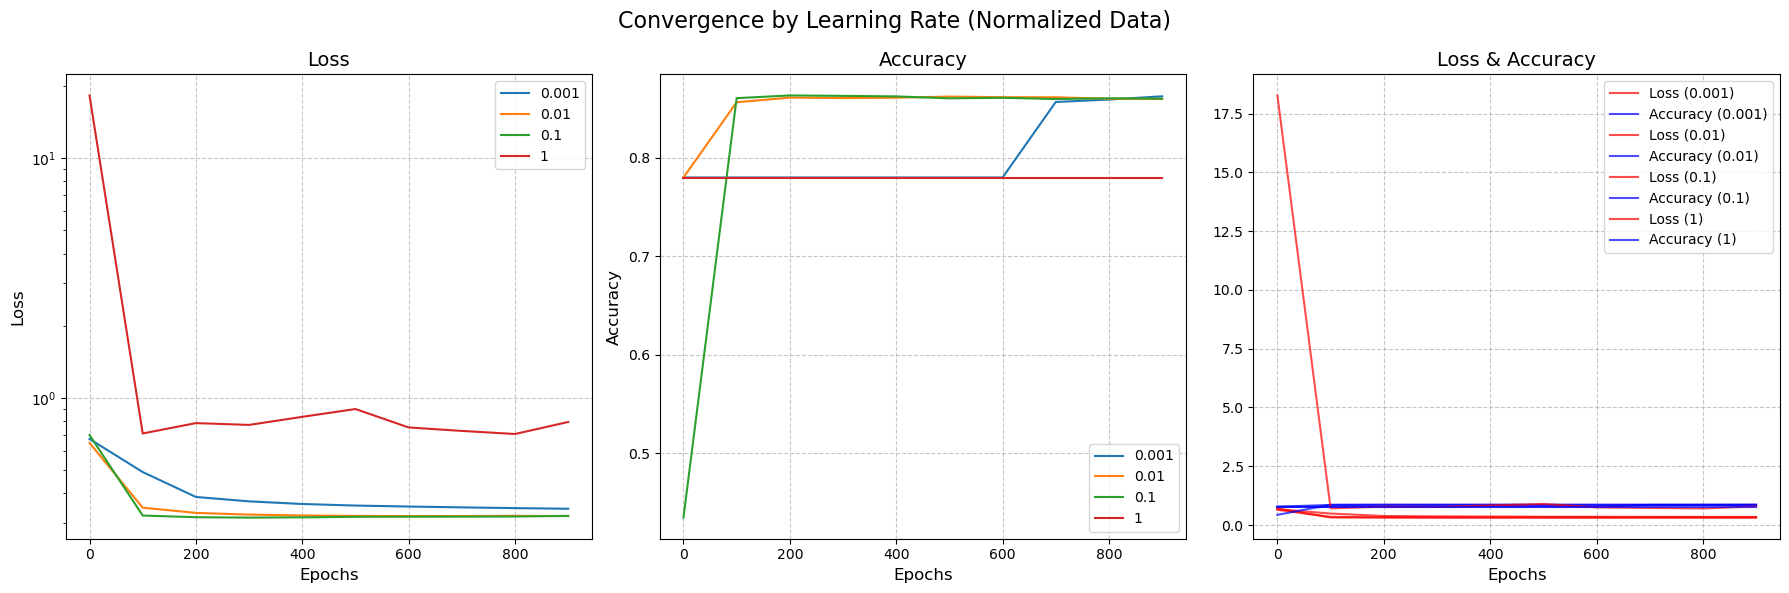

In [44]:
#2 Нормализация данных
results_norm = {}

for lr in learning_rates:
    net = Net(n_features=X_train_norm.shape[1], activation_fn=F.relu)  # Создаем модель для нормализованных данных
    optimizer = optim.Adam(net.parameters(), lr=lr)
    losses, accuracies = calc_by_epochs(X_train_norm, X_test_norm, y_train_norm, y_test_norm, 1000, net, optimizer)
    results_norm[lr] = {'losses': losses, 'accuracies': accuracies}

visualize_results(results_norm, title="Convergence by Learning Rate (Normalized Data)")

Epoch 0, Loss: 13.66076946258545, Accuracy: 0.7797766923904419
Epoch 100, Loss: 13.660667419433594, Accuracy: 0.7797766923904419
Epoch 200, Loss: 13.660567283630371, Accuracy: 0.7797766923904419
Epoch 300, Loss: 13.660465240478516, Accuracy: 0.7797766923904419
Epoch 400, Loss: 13.660362243652344, Accuracy: 0.7797766923904419
Epoch 500, Loss: 13.660260200500488, Accuracy: 0.7797766923904419
Epoch 600, Loss: 13.66015911102295, Accuracy: 0.7797766923904419
Epoch 700, Loss: 13.660056114196777, Accuracy: 0.7797766923904419
Epoch 800, Loss: 13.659955024719238, Accuracy: 0.7797766923904419
Epoch 900, Loss: 13.659852981567383, Accuracy: 0.7797766923904419
Epoch 0, Loss: 4.4362101554870605, Accuracy: 0.7797766923904419
Epoch 100, Loss: 0.5247600078582764, Accuracy: 0.7797766923904419
Epoch 200, Loss: 0.5232930779457092, Accuracy: 0.7797766923904419
Epoch 300, Loss: 0.5212028622627258, Accuracy: 0.7797766923904419
Epoch 400, Loss: 0.518241822719574, Accuracy: 0.7797766923904419
Epoch 500, Loss: 

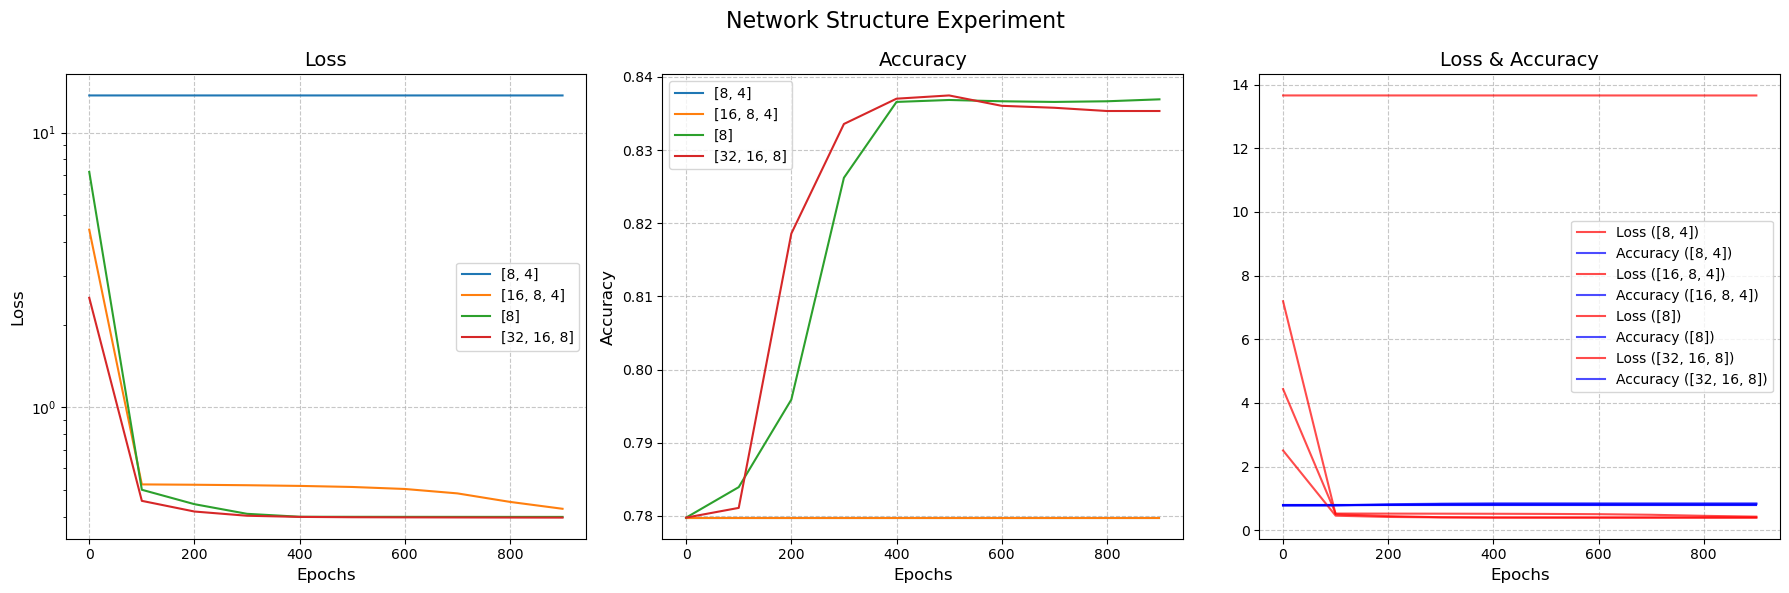

In [45]:
#Функция для экспериментов с различной структурой сети
def experiment_with_network_structure(X_train, X_test, y_train, y_test, hidden_layers_combinations):
    results_structure = {}

    for hidden_layers in hidden_layers_combinations:
        net = Net(n_features=X_train.shape[1], hidden_layers=hidden_layers, activation_fn=F.relu)
        optimizer = optim.Adam(net.parameters(), lr=0.001)  # Для примера используем Adam с lr=0.001
        losses, accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, 1000, net, optimizer)

        results_structure[str(hidden_layers)] = {'losses': losses, 'accuracies': accuracies}

    return results_structure

# Определяем различные комбинации скрытых слоев
hidden_layers_combinations = [
    [8, 4],      # Стандартная структура
    [16, 8, 4],  # Дополнительный скрытый слой
    [8],         # Только один скрытый слой
    [32, 16, 8]  # Увеличение числа нейронов в скрытых слоях
]


results_structure = experiment_with_network_structure(X_train, X_test, y_train, y_test, hidden_layers_combinations)
visualize_results(results_structure, title="Network Structure Experiment")

Epoch 0, Loss: 7.1905388832092285, Accuracy: 0.7797766923904419
Epoch 100, Loss: 0.6349822282791138, Accuracy: 0.7797766923904419
Epoch 200, Loss: 0.6135249733924866, Accuracy: 0.7797766923904419
Epoch 300, Loss: 0.5962961912155151, Accuracy: 0.7797766923904419
Epoch 400, Loss: 0.582206666469574, Accuracy: 0.7797766923904419
Epoch 500, Loss: 0.5706689357757568, Accuracy: 0.7797766923904419
Epoch 600, Loss: 0.5612606406211853, Accuracy: 0.7797766923904419
Epoch 700, Loss: 0.5536391735076904, Accuracy: 0.7797766923904419
Epoch 800, Loss: 0.5475137233734131, Accuracy: 0.7797766923904419
Epoch 900, Loss: 0.5426353812217712, Accuracy: 0.7797766923904419
Epoch 0, Loss: 0.75826096534729, Accuracy: 0.2202233225107193
Epoch 100, Loss: 0.6517861485481262, Accuracy: 0.7797766923904419
Epoch 200, Loss: 0.5801558494567871, Accuracy: 0.7797766923904419
Epoch 300, Loss: 0.5426891446113586, Accuracy: 0.7797766923904419
Epoch 400, Loss: 0.5257786512374878, Accuracy: 0.7797766923904419
Epoch 500, Loss: 

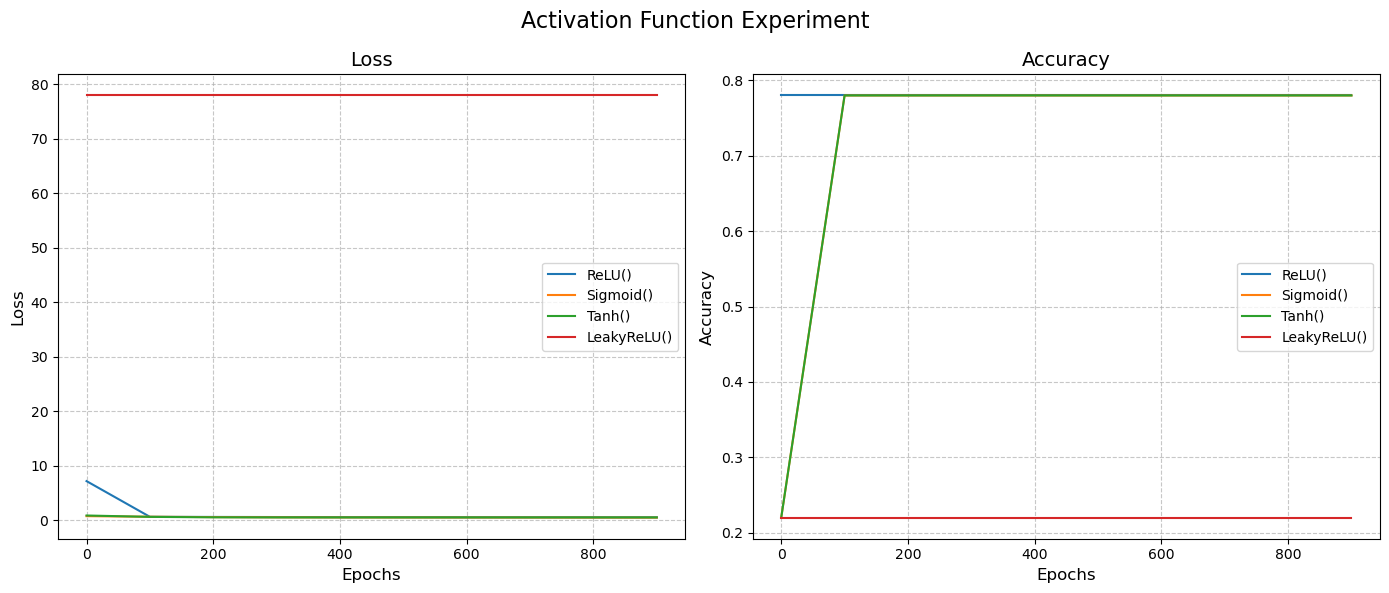

In [48]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Определение оберток для функций активации
class Sigmoid(nn.Module):
    def forward(self, x):
        return torch.sigmoid(x)

class Tanh(nn.Module):
    def forward(self, x):
        return torch.tanh(x)

class LeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.01):
        super(LeakyReLU, self).__init__()
        self.negative_slope = negative_slope

    def forward(self, x):
        return F.leaky_relu(x, self.negative_slope)

# Модель нейронной сети
class Net(nn.Module):
    def __init__(self, n_features, hidden_layers=[8, 4], activation_fn=nn.ReLU()):
        super(Net, self).__init__()
        layers = []
        input_size = n_features
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(activation_fn)  # Используем обертку для функции активации
            input_size = hidden_size
        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())  # Для бинарной классификации
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Подсчет точности
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(0.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

def calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer, criterion=nn.BCELoss()):
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(num_epochs):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_acc = calculate_accuracy(y_test, y_test_pred)

            print(f'Epoch {epoch}, Loss: {test_loss.item()}, Accuracy: {test_acc.item()}')
            epoch_losses.append(test_loss.item())
            epoch_accuracies.append(test_acc.item())

    return epoch_losses, epoch_accuracies

# Эксперимент с различными функциями активации
def experiment_with_activation(X_train, X_test, y_train, y_test, activation_functions):
    results_activation = {}

    for activation_fn in activation_functions:
        net = Net(n_features=X_train.shape[1], activation_fn=activation_fn)
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        losses, accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, 1000, net, optimizer)

        results_activation[str(activation_fn)] = {'losses': losses, 'accuracies': accuracies}

    return results_activation

# Визуализация результатов
def visualize_results(results, title=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 строка, 2 столбца

    for param, metrics in results.items():
        losses = metrics["losses"]
        accuracies = metrics["accuracies"]
        epochs = range(0, len(losses) * 100, 100)
        
        # Loss plot
        axes[0].plot(epochs, losses, label=f'{param}')
        axes[0].set_title("Loss", fontsize=14)
        axes[0].set_xlabel("Epochs", fontsize=12)
        axes[0].set_ylabel("Loss", fontsize=12)
        axes[0].grid(True, linestyle="--", alpha=0.7)

        # Accuracy plot
        axes[1].plot(epochs, accuracies, label=f'{param}')
        axes[1].set_title("Accuracy", fontsize=14)
        axes[1].set_xlabel("Epochs", fontsize=12)
        axes[1].set_ylabel("Accuracy", fontsize=12)
        axes[1].grid(True, linestyle="--", alpha=0.7)

    for ax in axes:
        ax.legend(fontsize=10)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Список функций активации
activation_functions = [nn.ReLU(), Sigmoid(), Tanh(), LeakyReLU()]

# Выполняем эксперимент
results_activation = experiment_with_activation(X_train, X_test, y_train, y_test, activation_functions)

# Визуализируем результаты
visualize_results(results_activation, title="Activation Function Experiment")

Epoch 0, Loss: 18.37946319580078, Accuracy: 0.7797766923904419
Epoch 100, Loss: 18.37946319580078, Accuracy: 0.7797766923904419
Epoch 200, Loss: 18.37946319580078, Accuracy: 0.7797766923904419
Epoch 300, Loss: 18.37946319580078, Accuracy: 0.7797766923904419
Epoch 400, Loss: 18.37946319580078, Accuracy: 0.7797766923904419
Epoch 500, Loss: 18.37946319580078, Accuracy: 0.7797766923904419
Epoch 600, Loss: 18.37946319580078, Accuracy: 0.7797766923904419
Epoch 700, Loss: 18.37946319580078, Accuracy: 0.7797766923904419
Epoch 800, Loss: 18.37946319580078, Accuracy: 0.7797766923904419
Epoch 900, Loss: 18.37946319580078, Accuracy: 0.7797766923904419
Epoch 0, Loss: 77.97766876220703, Accuracy: 0.2202233225107193
Epoch 100, Loss: 77.97766876220703, Accuracy: 0.2202233225107193
Epoch 200, Loss: 77.97766876220703, Accuracy: 0.2202233225107193
Epoch 300, Loss: 77.97766876220703, Accuracy: 0.2202233225107193
Epoch 400, Loss: 77.97766876220703, Accuracy: 0.2202233225107193
Epoch 500, Loss: 77.977668762

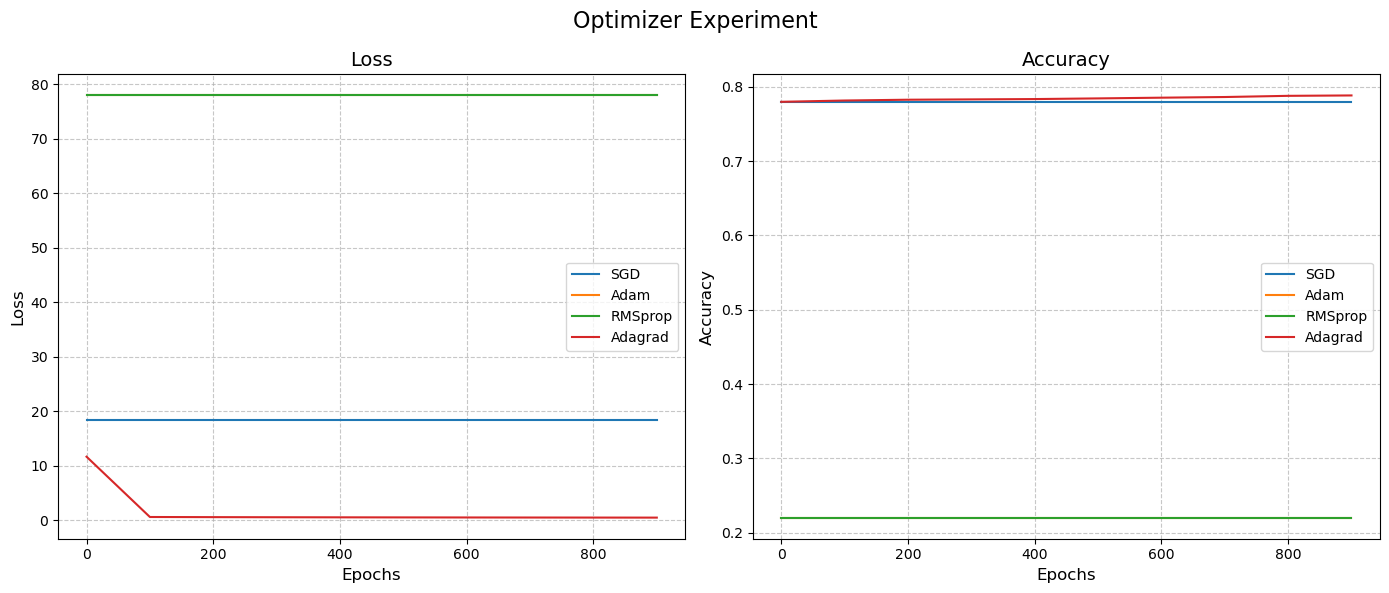

In [50]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Модель нейронной сети
class Net(nn.Module):
    def __init__(self, n_features, hidden_layers=[8, 4], activation_fn=nn.ReLU()):
        super(Net, self).__init__()
        layers = []
        input_size = n_features
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(activation_fn)  # Используем модуль активации
            input_size = hidden_size
        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())  # Для бинарной классификации
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Подсчет точности
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(0.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

def calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer, criterion=nn.BCELoss()):
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(num_epochs):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_acc = calculate_accuracy(y_test, y_test_pred)

            print(f'Epoch {epoch}, Loss: {test_loss.item()}, Accuracy: {test_acc.item()}')
            epoch_losses.append(test_loss.item())
            epoch_accuracies.append(test_acc.item())

    return epoch_losses, epoch_accuracies

# Эксперимент с различными методами оптимизации
def experiment_with_optimizer(X_train, X_test, y_train, y_test, optimizers):
    results_optimizer = {}

    for optimizer_name, optimizer_fn in optimizers:
        net = Net(n_features=X_train.shape[1], activation_fn=nn.ReLU())  # Исправлено: используем nn.ReLU()
        optimizer = optimizer_fn(net.parameters(), lr=0.001)
        losses, accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, 1000, net, optimizer)

        results_optimizer[optimizer_name] = {'losses': losses, 'accuracies': accuracies}

    return results_optimizer

# Визуализация результатов
def visualize_results(results, title=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 строка, 2 столбца

    for param, metrics in results.items():
        losses = metrics["losses"]
        accuracies = metrics["accuracies"]
        epochs = range(0, len(losses) * 100, 100)
        
        # Loss plot
        axes[0].plot(epochs, losses, label=f'{param}')
        axes[0].set_title("Loss", fontsize=14)
        axes[0].set_xlabel("Epochs", fontsize=12)
        axes[0].set_ylabel("Loss", fontsize=12)
        axes[0].grid(True, linestyle="--", alpha=0.7)

        # Accuracy plot
        axes[1].plot(epochs, accuracies, label=f'{param}')
        axes[1].set_title("Accuracy", fontsize=14)
        axes[1].set_xlabel("Epochs", fontsize=12)
        axes[1].set_ylabel("Accuracy", fontsize=12)
        axes[1].grid(True, linestyle="--", alpha=0.7)

    for ax in axes:
        ax.legend(fontsize=10)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Список оптимизаторов
optimizers = [
    ('SGD', optim.SGD),
    ('Adam', optim.Adam),
    ('RMSprop', optim.RMSprop),
    ('Adagrad', optim.Adagrad)
]

# Выполняем эксперимент
results_optimizer = experiment_with_optimizer(X_train, X_test, y_train, y_test, optimizers)

# Визуализируем результаты
visualize_results(results_optimizer, title="Optimizer Experiment")

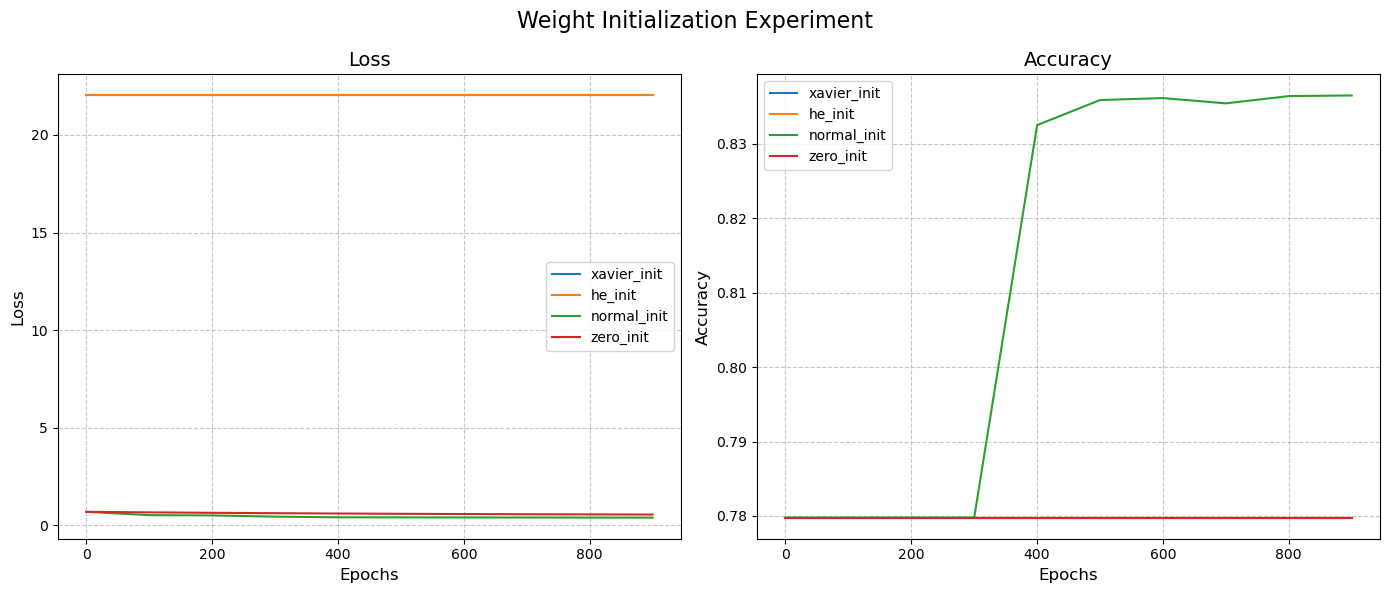

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Модель с возможностью изменения инициализации весов
class Net(nn.Module):
    def __init__(self, n_features, hidden_layers=[8, 4], activation_fn=nn.ReLU, weight_init=None):
        super(Net, self).__init__()
        layers = []
        input_size = n_features
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            
            # Используем активации как модули, а не функции
            if activation_fn == nn.ReLU:
                layers.append(nn.ReLU())
            elif activation_fn == nn.Sigmoid:
                layers.append(nn.Sigmoid())
            elif activation_fn == nn.Tanh:
                layers.append(nn.Tanh())
            elif activation_fn == nn.LeakyReLU:
                layers.append(nn.LeakyReLU())
            
            input_size = hidden_size
        
        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())  # Выходной слой с Sigmoid
        self.model = nn.ModuleList(layers)

        # Инициализация весов
        if weight_init:
            self.apply(weight_init)

    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

# Функции для инициализации весов
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def he_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def normal_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def zero_init(m):
    if isinstance(m, nn.Linear):
        nn.init.zeros_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Функция для вычисления потерь и точности по эпохам
def calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer, criterion=nn.BCELoss()):
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(num_epochs):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())  # Преобразуем y_train в float

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Вычисление потерь и точности на тестовом наборе
        y_test_pred = net(X_test).squeeze()
        test_loss = criterion(y_test_pred, y_test.float())  # Преобразуем y_test в float
        test_acc = (y_test_pred.ge(0.5).view(-1) == y_test).sum().float() / len(y_test)

        if epoch % 100 == 0:
            epoch_losses.append(test_loss.item())
            epoch_accuracies.append(test_acc.item())
    
    return epoch_losses, epoch_accuracies

# Эксперимент с различными методами инициализации весов
def experiment_with_weight_init(X_train, X_test, y_train, y_test, weight_init_functions):
    results_init = {}

    for init_fn in weight_init_functions:
        net = Net(n_features=X_train.shape[1], activation_fn=nn.ReLU, weight_init=init_fn)
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        losses, accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, 1000, net, optimizer)

        results_init[str(init_fn.__name__)] = {'losses': losses, 'accuracies': accuracies}

    return results_init

# Визуализация результатов
def visualize_results(results, title=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 строка, 2 столбца

    for param, metrics in results.items():
        losses = metrics["losses"]
        accuracies = metrics["accuracies"]
        epochs = range(0, len(losses) * 100, 100)
        
        # Loss plot
        axes[0].plot(epochs, losses, label=f'{param}')
        axes[0].set_title("Loss", fontsize=14)
        axes[0].set_xlabel("Epochs", fontsize=12)
        axes[0].set_ylabel("Loss", fontsize=12)
        axes[0].grid(True, linestyle="--", alpha=0.7)

        # Accuracy plot
        axes[1].plot(epochs, accuracies, label=f'{param}')
        axes[1].set_title("Accuracy", fontsize=14)
        axes[1].set_xlabel("Epochs", fontsize=12)
        axes[1].set_ylabel("Accuracy", fontsize=12)
        axes[1].grid(True, linestyle="--", alpha=0.7)

    for ax in axes:
        ax.legend(fontsize=10)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Список функций инициализации весов
weight_init_functions = [xavier_init, he_init, normal_init, zero_init]

# Выполняем эксперимент
results_weight_init = experiment_with_weight_init(X_train, X_test, y_train, y_test, weight_init_functions)

# Визуализируем результаты
visualize_results(results_weight_init, title="Weight Initialization Experiment")